In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [43]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 25

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
 "PlantVillage",
 seed=123,
 shuffle=True,
 image_size= (IMAGE_SIZE,IMAGE_SIZE),
 batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [32]:
class_names = dataset.class_names
class_names


['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [33]:
len(dataset)

68

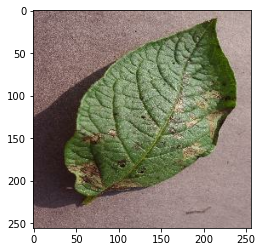

In [8]:
for image_batch, label_batch in dataset.take(1):
 # print(image_batch[0])
 plt.imshow(image_batch[0].numpy().astype("uint8"))

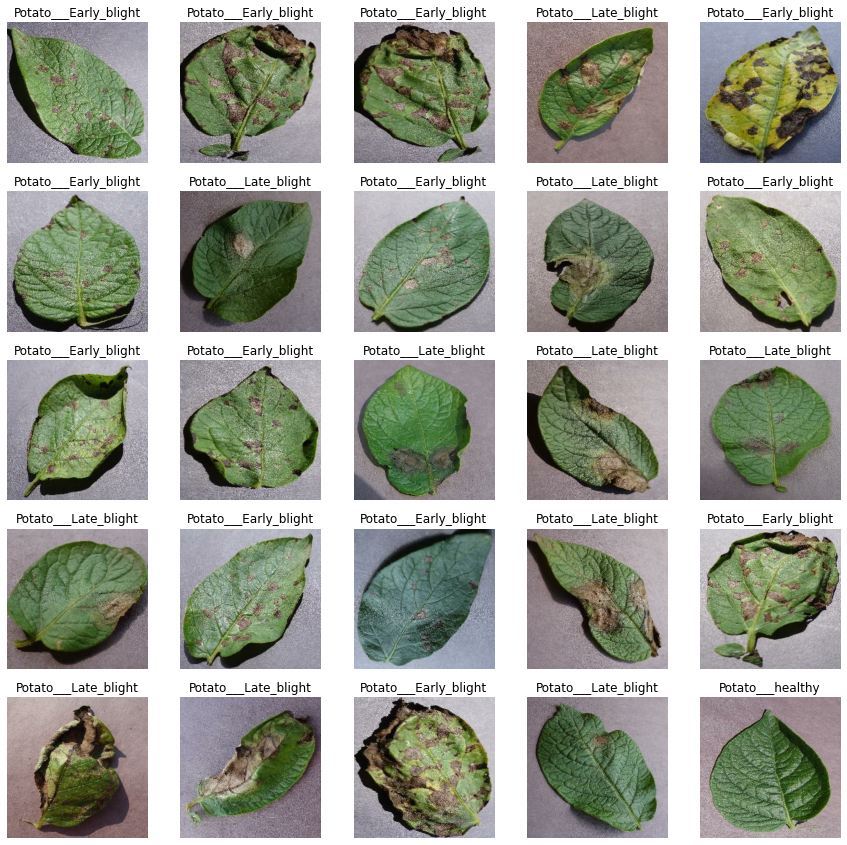

In [10]:
plt.figure(figsize=(15, 15))
for image_batch, label_batch in dataset.take(1):
 for i in range(25):
   ax = plt.subplot(5,5,i+1)
   plt.imshow(image_batch[i].numpy().astype("uint8"))
   plt.title(class_names[label_batch[i]])
   plt.axis("off")

In [34]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [12]:
train_ds = dataset.take(54)
len(train_ds)

54

In [13]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [14]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [15]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [16]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [18]:
def get_dataset_splits(ds, train_splits = 0.8, val_splits = 0.1, test_splits = 0.1, shuffle = True, shuffle_size = 1000):
 ds_size = len(ds)
 if shuffle:
   ds = ds.shuffle(shuffle_size, seed = 100)
 train_size = int(train_splits * ds_size)
 val_size = int(val_splits * ds_size)
 
 train_ds = ds.take(train_size)
 
 val_ds = ds.skip(train_size).take(val_size)
 test_ds = ds.skip(train_size).skip(val_size)
 
 return train_ds, val_ds, test_ds

In [19]:
train_ds, val_ds, test_ds = get_dataset_splits(dataset)

In [20]:
ttrain_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [21]:
resize_and_rescale = tf.keras.Sequential([
 layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
 layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [22]:
data_augmentation = tf.keras.Sequential([
 layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
 layers.experimental.preprocessing.RandomRotation(0.2),
])

In [23]:
train_ds = train_ds.map(
 lambda x, y: (data_augmentation(x, training = True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [24]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

In [25]:
model = models.Sequential([
 resize_and_rescale,
 data_augmentation,
 layers.Conv2D(32, (3,3), activation = 'relu', input_shape = input_shape),
 layers.MaxPooling2D((2,2)),
 layers.Conv2D(64, (3,3), activation = 'relu'),
 layers.MaxPooling2D((2,2)),
 layers.Conv2D(64, (3,3), activation = 'relu'),
 layers.MaxPooling2D((2,2)),
 layers.Conv2D(64, (3,3), activation = 'relu'),
 layers.MaxPooling2D((2,2)),
 layers.Conv2D(64, (3,3), activation = 'relu'),
 layers.MaxPooling2D((2,2)),
 layers.Conv2D(64, (3,3), activation = 'relu'),
 layers.MaxPooling2D((2,2)),
 layers.Flatten(),
 layers.Dense(64, activation = 'relu'),
 layers.Dense(n_classes, activation='softmax'),
 
])
model.build(input_shape=input_shape)

In [26]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [28]:
model.compile(
 optimizer='adam',
 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
 metrics=["accuracy"]
)

In [29]:
history = model.fit(
 train_ds,
 epochs=25,
 batch_size=BATCH_SIZE,
 verbose=1,
 validation_data=val_ds
)

Epoch 1/25
54/54 [==============================] - 151s 3s/step - loss: 0.9037 - accuracy: 0.5112 - val_loss: 0.9086 - val_accuracy: 0.5573
Epoch 2/25
54/54 [==============================] - 151s 3s/step - loss: 0.6379 - accuracy: 0.7218 - val_loss: 0.6065 - val_accuracy: 0.7240
Epoch 3/25
54/54 [==============================] - 338s 6s/step - loss: 0.4150 - accuracy: 0.8263 - val_loss: 0.3871 - val_accuracy: 0.8646
Epoch 4/25
54/54 [==============================] - 132s 2s/step - loss: 0.3399 - accuracy: 0.8669 - val_loss: 0.3162 - val_accuracy: 0.8698
Epoch 5/25
54/54 [==============================] - 144s 3s/step - loss: 0.2776 - accuracy: 0.8809 - val_loss: 0.2856 - val_accuracy: 0.8854
Epoch 6/25
54/54 [==============================] - 148s 3s/step - loss: 0.2360 - accuracy: 0.8996 - val_loss: 0.1376 - val_accuracy: 0.9531
Epoch 7/25
54/54 [==============================] - 148s 3s/step - loss: 0.2300 - accuracy: 0.9131 - val_loss: 0.4456 - val_accuracy: 0.7865
Epoch 8/25
54

In [35]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 7s 652ms/step - loss: 0.1037 - accuracy: 0.9492


In [36]:
scores

[0.10371845960617065, 0.94921875]

In [38]:
history.params

{'verbose': 1, 'epochs': 25, 'steps': 54}

In [39]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

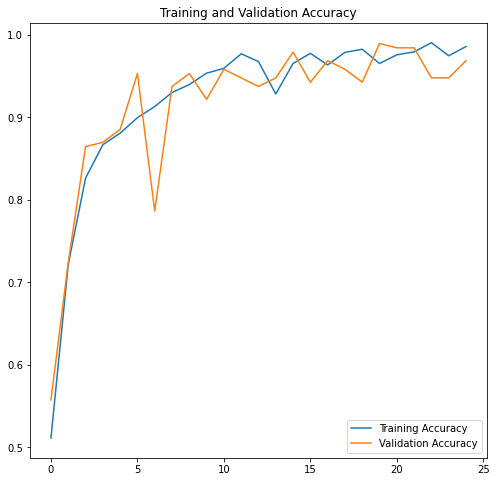

In [47]:
plt.figure(figsize=(18,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

Text(0.5, 1.0, 'Training and Validation Accuracy')

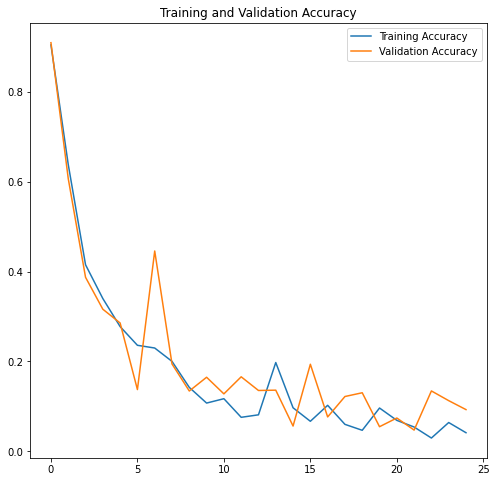

In [49]:
plt.figure(figsize=(18,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), loss, label='Training Accuracy')
plt.plot(range(EPOCHS), val_loss, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')

first image to predict
first image's actual label: Potato___Late_blight
predicted label : Potato___Late_blight


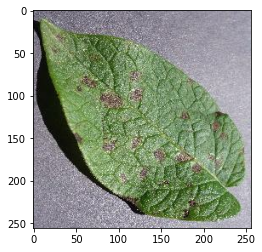

In [59]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("first image's actual label:", class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label :", class_names[np.argmax(batch_prediction[0])])

In [66]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # batch creation
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

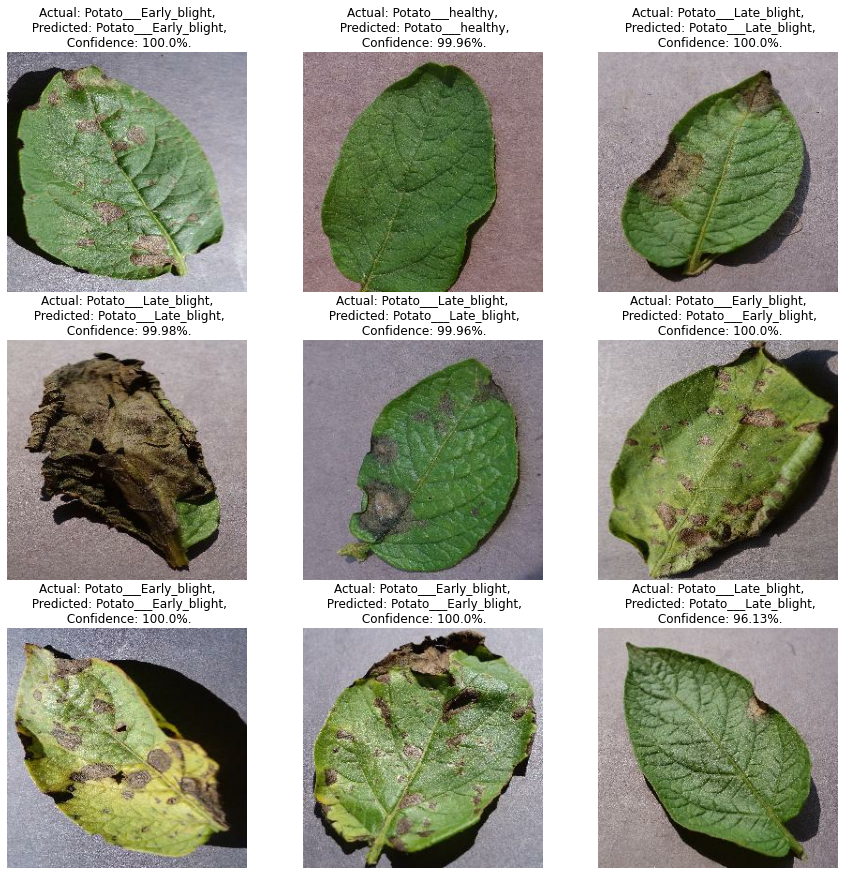

In [68]:
plt.figure(figsize = (15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class},\n Confidence: {confidence}%.")
        plt.axis("off")

In [72]:
model_version=1
model.save(f'./models/{model_version}')

INFO:tensorflow:Assets written to: ./models/1\assets
